# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

$\min \; Z =
\underbrace{
w_{\text{main}} \cdot \left(
w_t \cdot \sum_{j \in \mathcal{J}} T_j
+ w_e \cdot \sum_{j \in \mathcal{J}} E_j
+ w_{\text{first}} \cdot \sum_{j \in \mathcal{J}} F_j
\right)
}_{\text{Lateness-Komponente}}
\; + \;
\underbrace{
(1 - w_{\text{main}}) \cdot \sum_{(j,o) \in \mathcal{P}} D_{jo}
}_{\text{Abweichungskomponente}}$

$\mathcal{J}$ … Menge aller Jobs
$\mathcal{P}$ … Menge aller Operationen mit vorherigem Planbezug

$T_j = \max(0, \text{Ende}_j - \text{Deadline}_j)$ … Tardiness (Verspätung)
$E_j = \max(0, \text{Deadline}_j - \text{Ende}_j)$ … Earliness (zu früh)
$F_j = \max(0, \text{Wunschstart}_j - \text{Start}_{j,0})$ … Frühstartstrafe der ersten Operation

$D_{jo} =
\begin{cases}
|S_{jo}^{\text{neu}} - S_{jo}^{\text{alt}}| & \text{(Startzeitabweichung)} \\
\text{Anzahl der Inversionen (Kendall-Tau)} & \text{(Reihenfolgeabweichung)}
\end{cases}$


In [2]:
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.rolling_process.rolling_filter import *
from src.utils.editor import enrich_schedule_dframe

from src.utils.logging import print_experiment_log

# Analysis utils
from src.utils.analysis_basics import check_constraints as check
from src.utils.analysis_basics.check_lateness import get_jobs_with_lateness_metrics, get_jobs_aggregated
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.converter import get_job_ops_dict, get_times_dict, get_schedule_dframe, get_active_ops
from src.solvers.cp.lateness import solve_jssp_lateness_with_start_deviation_minimization, \
    solve_jssp_lateness_with_order_deviation_minimization

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [3]:
# Hard termination condition for schedulers
max_time = 60*2     # 2 min

# File paths
examples_data_path = get_path("data", "examples")
basic_data_path = get_path("data", "basic")

# Simulation
simulation = ProductionSimulation(sigma = 0.2)

In [4]:
# Load files
df_routings = pd.read_csv(basic_data_path / "ft10_routings.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


In [5]:
df_jobs_times = pd.read_csv(basic_data_path / "ft10_jobs_times.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,0,1440,597,3065
1,J25-0001,6,49,1440,416,3493
2,J25-0002,0,116,1440,395,3849
3,J25-0003,2,160,1440,568,4606
4,J25-0004,3,203,1440,655,3025
5,J25-0005,1,409,1440,510,2717
...,...,...,...,...,...,...
7407,J25-7407,1,517827,518400,510,520076
7408,J25-7408,7,517932,518400,539,520867
7409,J25-7409,4,518012,518400,393,520867


In [6]:
df_jssp = df_jobs_times[["Job", "Routing_ID"]].merge(df_routings, on="Routing_ID",how="left")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
74124,J25-7412,2,4,M08,90
74125,J25-7412,2,5,M05,10
74126,J25-7412,2,6,M07,12


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [7]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [8]:
# New and unfinished jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,0,1440,597,3065
1,J25-0001,6,49,1440,416,3493
2,J25-0002,0,116,1440,395,3849
3,J25-0003,2,160,1440,568,4606
4,J25-0004,3,203,1440,655,3025
5,J25-0005,1,409,1440,510,2717
...,...,...,...,...,...,...
11,J25-0011,9,930,1440,540,3553
12,J25-0012,5,1002,1440,496,3821
13,J25-0013,7,1089,1440,539,3246


In [9]:
# current JSSP (Job Shop Scheduling Problem) basic data
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current, exclusion_dataframes_list = None)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
164,J25-0016,1,4,M03,69
165,J25-0016,1,5,M01,28
166,J25-0016,1,6,M06,46


### Scheduling Preperation

In [10]:
job_ops_dict = get_job_ops_dict(df_jssp_current)
job_ops_dict

{'J25-0000': [(0, 'M00', 76),
  (1, 'M01', 69),
  (2, 'M03', 76),
  (3, 'M05', 51),
  (4, 'M02', 85),
  (5, 'M09', 11),
  (6, 'M06', 40),
  (7, 'M07', 89),
  (8, 'M04', 26),
  (9, 'M08', 74)],
 'J25-0001': [(0, 'M01', 46),
  (1, 'M00', 37),
  (2, 'M03', 61),
  (3, 'M02', 13),
  (4, 'M06', 32),
  (5, 'M05', 21),
  (6, 'M09', 32),
  (7, 'M08', 89),
  (8, 'M07', 30),
  (9, 'M04', 55)],
 'J25-0002': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0003': [(0, 'M01', 91),
  (1, 'M00', 85),
  (2, 'M03', 39),
  (3, 'M02', 74),
  (4, 'M08', 90),
  (5, 'M05', 10),
  (6, 'M07', 12),
  (7, 'M06', 89),
  (8, 'M09', 45),
  (9, 'M04', 33)],
 'J25-0004': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0005': [(0, 'M00', 43),
  (1, '

In [11]:
times_dict = get_times_dict(df_jobs_times_current)
times_dict

{'J25-0000': (1440, 3065),
 'J25-0001': (1440, 3493),
 'J25-0002': (1440, 3849),
 'J25-0003': (1440, 4606),
 'J25-0004': (1440, 3025),
 'J25-0005': (1440, 2717),
 'J25-0006': (1440, 3714),
 'J25-0007': (1440, 4586),
 'J25-0008': (1440, 3521),
 'J25-0009': (1440, 5114),
 'J25-0010': (1440, 3431),
 'J25-0011': (1440, 3553),
 'J25-0012': (1440, 3821),
 'J25-0013': (1440, 3246),
 'J25-0014': (1440, 3940),
 'J25-0015': (1440, 4225),
 'J25-0016': (1440, 2994)}

In [12]:
from pydantic_models import JobInformationCollection

current_JobInformationCollection = JobInformationCollection.from_dataframe(df_jobs_times_current)
current_JobInformationCollection

{'J25-0000': JobInformation(earliest_start=1440, deadline=3065), 'J25-0001': JobInformation(earliest_start=1440, deadline=3493), 'J25-0002': JobInformation(earliest_start=1440, deadline=3849), 'J25-0003': JobInformation(earliest_start=1440, deadline=4606), 'J25-0004': JobInformation(earliest_start=1440, deadline=3025), 'J25-0005': JobInformation(earliest_start=1440, deadline=2717), 'J25-0006': JobInformation(earliest_start=1440, deadline=3714), 'J25-0007': JobInformation(earliest_start=1440, deadline=4586), 'J25-0008': JobInformation(earliest_start=1440, deadline=3521), 'J25-0009': JobInformation(earliest_start=1440, deadline=5114), 'J25-0010': JobInformation(earliest_start=1440, deadline=3431), 'J25-0011': JobInformation(earliest_start=1440, deadline=3553), 'J25-0012': JobInformation(earliest_start=1440, deadline=3821), 'J25-0013': JobInformation(earliest_start=1440, deadline=3246), 'J25-0014': JobInformation(earliest_start=1440, deadline=3940), 'J25-0015': JobInformation(earliest_sta

### Schedule

In [13]:
schedule, _ = solve_jssp_lateness_with_start_deviation_minimization(
        job_ops=job_ops_dict,
        times_dict=times_dict,
        previous_schedule=None,
        active_ops=None,
        w_t= 10, w_e=2, w_first=1,
        main_pct=1, duration_buffer_factor = 2,
        schedule_start=day_start, msg=False,
        solver_time_limit=max_time, solver_relative_gap_limit=0.05
    )

In [14]:
df_schedule = get_schedule_dframe(schedule)
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)
df_schedule

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,1871,76,1947
1,J25-0000,1,M01,1947,69,2016
2,J25-0000,2,M03,2016,76,2092
3,J25-0000,3,M05,2136,51,2187
4,J25-0000,4,M02,2199,85,2284
5,J25-0000,5,M09,2284,11,2295
...,...,...,...,...,...,...
164,J25-0016,4,M03,2237,69,2306
165,J25-0016,5,M01,2331,28,2359
166,J25-0016,6,M06,2359,46,2405


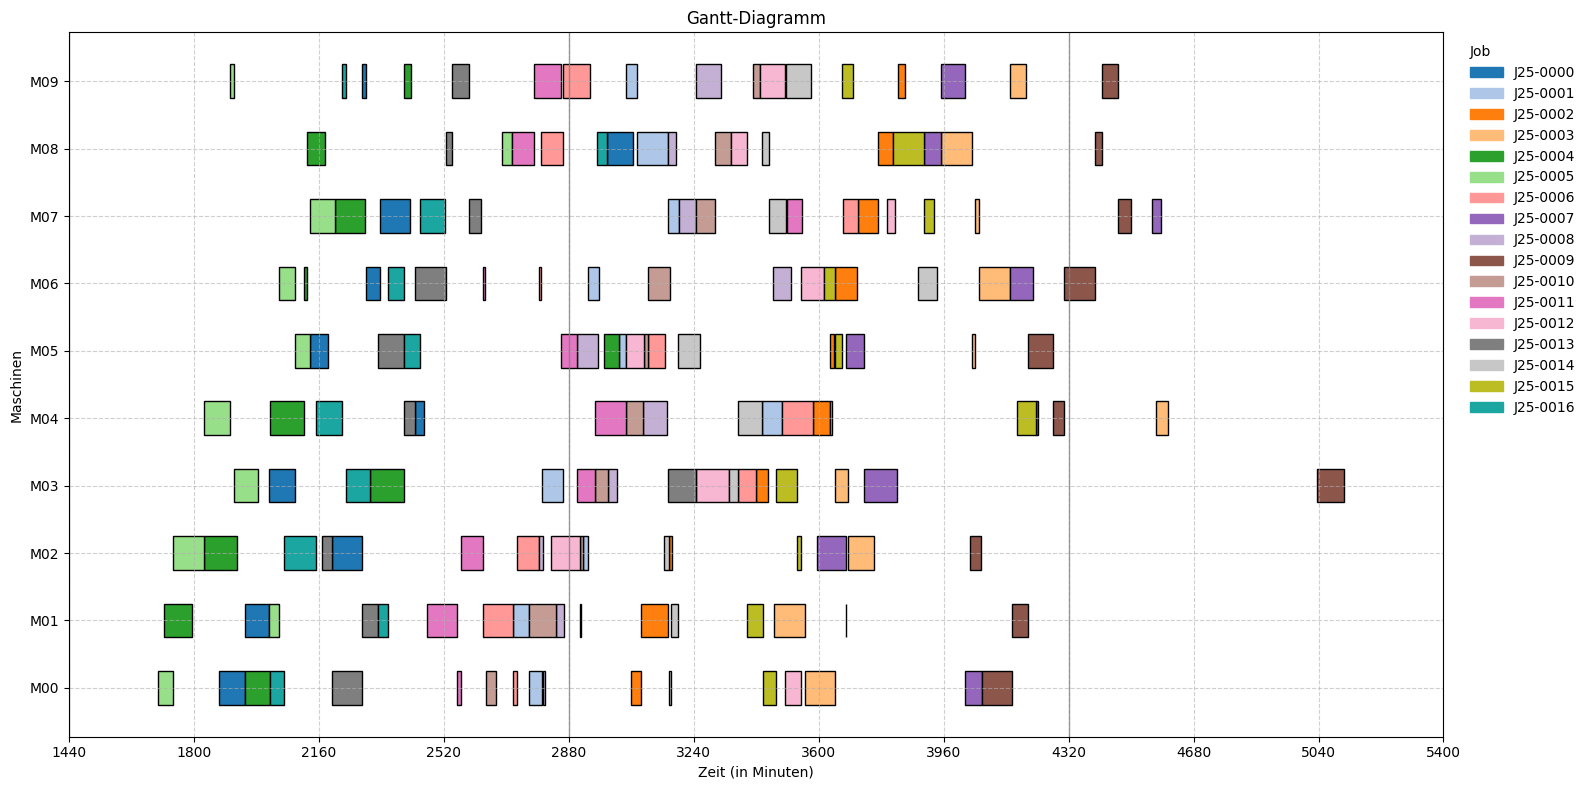

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [15]:
gantt.get_plot(df_schedule, perspective="Machine")
#df_schedule_with_info = enrich_schedule_dframe(df_schedule, df_jobs_times)
check.check_core_schedule_constraints(df_schedule)
check.is_start_correct(df_schedule, df_jobs_times_current)
check.is_duration_correct(df_schedule)


### Simulation

In [16]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 04:17:00] Job J25-0005 started on M00
[Day 1 04:35:00] Job J25-0004 started on M01
[Day 1 04:51:00] Job J25-0005 finished on M00 (after 34 minutes)
[Day 1 05:00:00] Job J25-0005 started on M02
[Day 1 05:49:00] Job J25-0004 finished on M01 (after 74 minutes)
[Day 1 05:54:00] Job J25-0005 finished on M02 (after 54 minutes)
[Day 1 06:30:00] Job J25-0004 started on M02
[Day 1 06:30:00] Job J25-0005 started on M04
[Day 1 07:11:00] Job J25-0000 started on M00
[Day 1 08:02:00] Job J25-0005 finished on M04 (after 92 minutes)
[Day 1 08:02:00] Job J25-0005 started on M09
[Day 1 08:17:00] Job J25-0005 finished on M09 (after 15 minutes)
[Day 1 08:17:00] Job J25-0005 started on M03
[Day 1 08:25:00] Job J25-0000 finished on M00 (after 74 minutes)
[Day 1 08:27:00] Job J25-0000 started on M01
[Day 1 08:28:00] Job J25-0004 finished on M02 (after 118 minutes)
[Day 1 08:28:00] Job J25-0004 started on M00
[Day 1 09:19:00] Job J25-0005 finished on M03 (after 62 minutes)
[Day 1 09:29:00] Job J25-0004

In [17]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,1871.0,74.0,1945.0
1,J25-0000,1,M01,1947.0,66.0,2013.0
2,J25-0000,2,M03,2016.0,84.0,2100.0
3,J25-0000,3,M05,2137.0,47.0,2184.0
4,J25-0000,4,M02,2204.0,64.0,2268.0
5,J25-0000,5,M09,2284.0,10.0,2294.0
...,...,...,...,...,...,...
59,J25-0016,3,M09,2272.0,12.0,2284.0
60,J25-0016,4,M03,2284.0,46.0,2330.0
61,J25-0016,5,M01,2363.0,26.0,2389.0


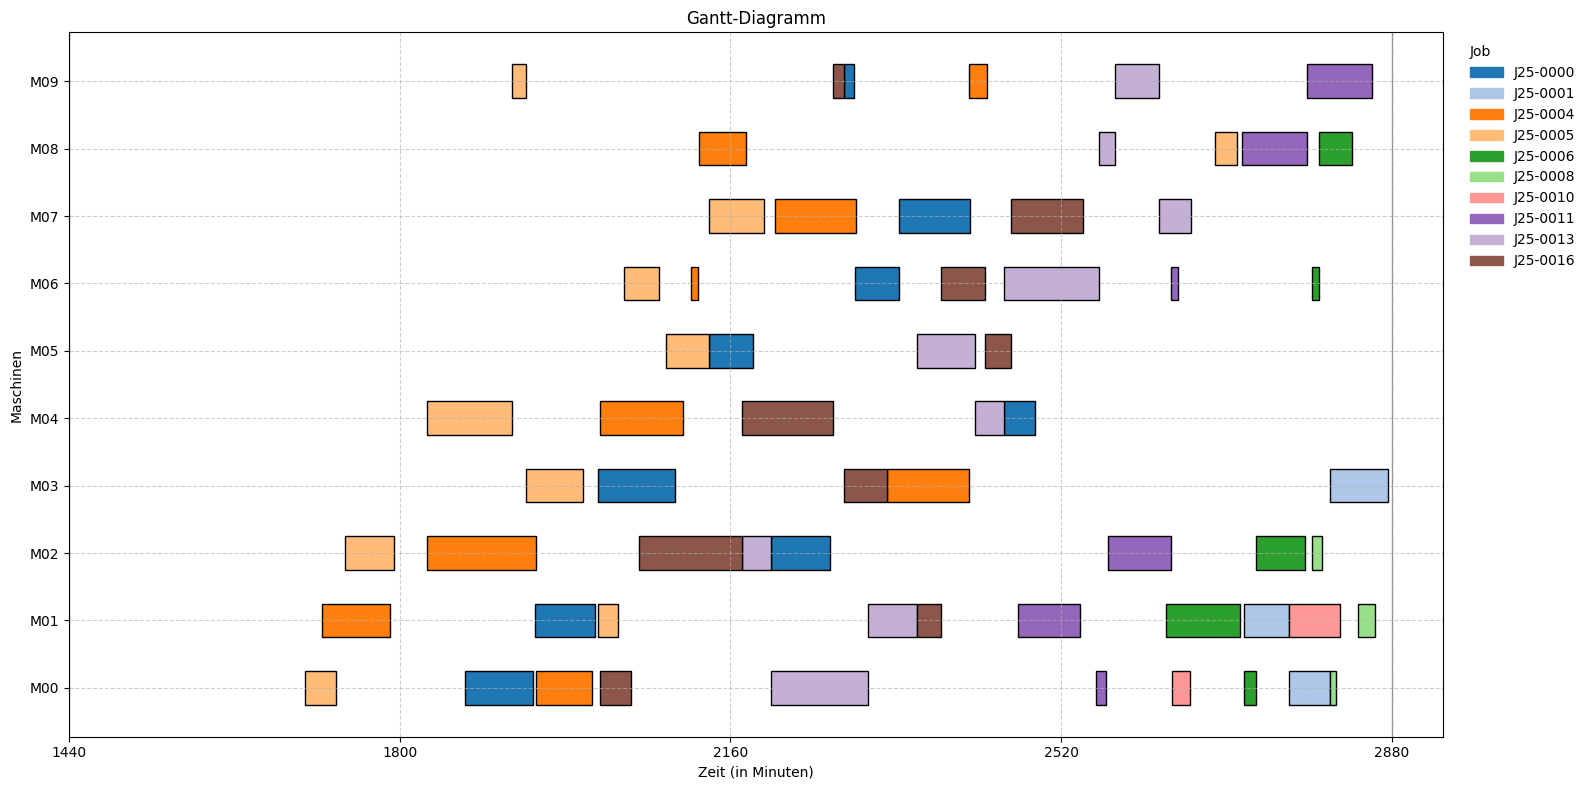

In [18]:
gantt.get_plot(df_execution, perspective="Machine")

In [19]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Start,Processing Time,End,Expected End
0,J25-0006,5,M09,2864.0,68.0,2932.0,2940.0
1,J25-0011,6,M05,2858.0,51.0,2909.0,2905.0
2,J25-0012,0,M02,2829.0,92.0,2921.0,2913.0


In [20]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,9,M08,2991,74,3065
1,J25-0001,3,M02,2922,13,2935
2,J25-0001,4,M06,2935,32,2967
3,J25-0001,5,M05,3025,21,3046
4,J25-0001,6,M09,3046,32,3078
5,J25-0001,7,M08,3078,89,3167
...,...,...,...,...,...,...
96,J25-0015,5,M05,3647,21,3668
97,J25-0015,6,M09,3668,32,3700
98,J25-0015,7,M08,3814,89,3903


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [21]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [22]:
# New and unfinished jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,0,1440,597,3065
1,J25-0001,6,49,1440,416,3493
2,J25-0002,0,116,1440,395,3849
3,J25-0003,2,160,1440,568,4606
4,J25-0004,3,203,1440,655,3025
6,J25-0006,9,695,1440,540,3714
...,...,...,...,...,...,...
33,J25-0033,2,2524,2880,568,5374
34,J25-0034,8,2579,2880,597,3965
35,J25-0035,5,2589,2880,496,4243


In [23]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
9,J25-0000,8,9,M08,74
13,J25-0001,6,3,M02,13
14,J25-0001,6,4,M06,32
15,J25-0001,6,5,M05,21
16,J25-0001,6,6,M09,32
17,J25-0001,6,7,M08,89
...,...,...,...,...,...
384,J25-0038,3,4,M06,9
385,J25-0038,3,5,M08,52
386,J25-0038,3,6,M07,85


### Scheduling Preparation

In [24]:
# jssp dict and job times information dict
job_ops_dict = get_job_ops_dict(df_jssp_current)
times_dict = get_times_dict(df_jobs_times_current)

In [25]:
active_ops = get_active_ops(df_active)
active_ops

[('J25-0006', 5, 'M09', 2864, 68, 2932),
 ('J25-0011', 6, 'M05', 2858, 51, 2909),
 ('J25-0012', 0, 'M02', 2829, 92, 2921)]

In [26]:
previous_schedule = schedule
df_previous_schedule = df_schedule

In [27]:
schedule

[('J25-0000', 0, 'M00', 1871, 76, 1947),
 ('J25-0000', 1, 'M01', 1947, 69, 2016),
 ('J25-0000', 2, 'M03', 2016, 76, 2092),
 ('J25-0000', 3, 'M05', 2136, 51, 2187),
 ('J25-0000', 4, 'M02', 2199, 85, 2284),
 ('J25-0000', 5, 'M09', 2284, 11, 2295),
 ('J25-0000', 6, 'M06', 2295, 40, 2335),
 ('J25-0000', 7, 'M07', 2335, 89, 2424),
 ('J25-0000', 8, 'M04', 2437, 26, 2463),
 ('J25-0000', 9, 'M08', 2991, 74, 3065),
 ('J25-0001', 0, 'M01', 2719, 46, 2765),
 ('J25-0001', 1, 'M00', 2765, 37, 2802),
 ('J25-0001', 2, 'M03', 2802, 61, 2863),
 ('J25-0001', 3, 'M02', 2922, 13, 2935),
 ('J25-0001', 4, 'M06', 2935, 32, 2967),
 ('J25-0001', 5, 'M05', 3025, 21, 3046),
 ('J25-0001', 6, 'M09', 3046, 32, 3078),
 ('J25-0001', 7, 'M08', 3078, 89, 3167),
 ('J25-0001', 8, 'M07', 3167, 30, 3197),
 ('J25-0001', 9, 'M04', 3438, 55, 3493),
 ('J25-0002', 0, 'M00', 3059, 29, 3088),
 ('J25-0002', 1, 'M01', 3088, 78, 3166),
 ('J25-0002', 2, 'M02', 3168, 9, 3177),
 ('J25-0002', 3, 'M03', 3419, 36, 3455),
 ('J25-0002', 4, 

In [28]:
-

SyntaxError: invalid syntax (3457752569.py, line 1)

### Scheduling (Rescheduling)

#### a) Simple Scheduling

In [ ]:
schedule, experiment_log = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=None,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=1,
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)


In [ ]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

In [ ]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

### b) with 'start' deviation penalty

In [ ]:
schedule, experiment_log = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=(1/2),                  # 50% Lateness+, 50% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"\nSum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

### c) with 'order on machines' deviation penalty

In [ ]:
schedule, experiment_log = solve_jssp_lateness_with_order_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=(1/2),                  # 50% Lateness+, 50% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.001
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"\nSum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

In [ ]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

#### Check the conditions of the combined data set from the simulation data with the new schedule

In [ ]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)

### Simulation

In [ ]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

In [ ]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

In [ ]:
gantt.get_plot(df_execution2, perspective="Machine")

In [ ]:
df_active2 = simulation.get_active_operations_df()
df_active2

#### Check the conditions of the combined data set from the two simulation data sets

In [ ]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)